###### © Habibi Group, Fall 2024
This the first model for the project. It uses a custom build vectorizer to make sparse vectors for each sentence and then uses cosine distance (dot product) as the nearess measure. The model is trained on the training data and then tested on the test data.

*THIS IS THE COMBINED DATA FLAVOR 2*

In [11]:
# Importing libraries
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

Preparing the dataset for the K-Nearest model.

In [12]:
# Loading data
df = pd.read_csv('../combined_data/dataset.csv')
df = df.dropna()
df.head()

,id,local_id,link,title,content,gold_label
0,1,1,https://urdu.arynews.tv/car-sales-in-pakistan/,پاکستان میں گاڑیوں کی فروخت میں بڑا اضافہ,ملکی آٹو سیکٹر سے زبردست خبر آگئی۔ پاکستان می...,Business
1,2,2,https://urdu.arynews.tv/gold-rates-in-pakistan-3/,پاکستان میں سونے کی قیمت آج کتنی کم ہوئی؟,کراچی: کاروباری ہفتے کے پہلے روز سونے کی قیمت ...,Business
2,3,5,https://urdu.arynews.tv/cotton-production-cott...,امریکا سے معیاری روئی کی درآمد بڑھ گئی,کراچی: پاکستان میں کپاس کی پیداوار میں کمی کے ...,Business
3,4,3,https://urdu.arynews.tv/psx-today-11-nov/,پاکستان اسٹاک ایکسچینج میں نئی تاریخ رقم,پاکستان اسٹاک ایکسچینج نے ایک اور سنگ میل عبور...,Business
4,5,4,https://urdu.arynews.tv/ghee-and-cooking-oil-p...,عوام کے لیے نئی مشکل : گھی اور کوکنگ آئل کی قی...,لاہور : گھی اور کوکنگ آئل کی قیمتوں میں ایک با...,Business


Cleaning the data and preprocessing.

In [13]:
#Preprocessing the data
# Add this function to perform stemming
def simple_urdu_stemmer(word):
    suffixes = ['یں', 'اں', 'وں', 'یں', 'ہاں', 'ی', 'ے', 'و', 'ہ']
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

# Loading Urdu stopwords from the json file
with open('../data/kaggle_stopwords.json', 'r', encoding='utf-8') as file:
    urdu_stopwords = set(json.load(file).keys())

#Loading Shanzae Stopwords
with open('../data/shanzae/stopwords.json', 'r', encoding='utf-8') as file:
    shanzae_stopwords = set(json.load(file).keys())

#Loading Yamsheen Stopwords
with open('../data/yamsheen/stopwords.json', 'r', encoding='utf-8') as file:
    yamsheen_stopwords = set(json.load(file).keys())

# Function to clean our Urdu sentences
def clean_content(text, stopwords):
    text = str(text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stopwords)
    text = ' '.join(word for word in text.split() if word not in shanzae_stopwords)
    text = ' '.join(word for word in text.split() if word not in yamsheen_stopwords)
    text = text.lower()
    text = ' '.join(simple_urdu_stemmer(word) for word in text.split())
    return text

df['content'] = df['content'].apply(lambda x: clean_content(x, urdu_stopwords))
df.head()

,id,local_id,link,title,content,gold_label
0,1,1,https://urdu.arynews.tv/car-sales-in-pakistan/,پاکستان میں گاڑیوں کی فروخت میں بڑا اضافہ,ملک آٹ سیکٹر س زبردست خبر آگئی۔ پاکستان گاڑی ...,Business
1,2,2,https://urdu.arynews.tv/gold-rates-in-pakistan-3/,پاکستان میں سونے کی قیمت آج کتنی کم ہوئی؟,کراچ کاروبار ہفت پہل روز سون قیمت رجحان رہا۔ پ...,Business
2,3,5,https://urdu.arynews.tv/cotton-production-cott...,امریکا سے معیاری روئی کی درآمد بڑھ گئی,کراچ پاکستان کپاس پیداوار باعث اسپننگ مل س معی...,Business
3,4,3,https://urdu.arynews.tv/psx-today-11-nov/,پاکستان اسٹاک ایکسچینج میں نئی تاریخ رقم,پاکستان اسٹاک ایکسچینج ن میل عبور لیا۔ کاروبار...,Business
4,5,4,https://urdu.arynews.tv/ghee-and-cooking-oil-p...,عوام کے لیے نئی مشکل : گھی اور کوکنگ آئل کی قی...,لاہور کوکنگ آئل قیمت اضاف ہوا، قمیت س تجاوز کر...,Business


Implementation of the KNN model.

In [14]:
# Custom TF-IDF Vectorizer from Scratch
class CustomTfidfVectorizer:
    def __init__(self, max_features=10000, ngram_range=(1, 3), min_df=2, max_df=0.95, sublinear_tf=True):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.sublinear_tf = sublinear_tf
        self.vocabulary_ = {}
        self.idf_ = None
        
    def _generate_ngrams(self, text, n):
        words = text.split()
        return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    
    def _build_vocabulary(self, documents):
        doc_freq = defaultdict(int)
        total_docs = len(documents)
        
        for doc in documents:
            term_set = set()
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                ngrams = self._generate_ngrams(doc, n)
                term_set.update(ngrams)
            for term in term_set:
                doc_freq[term] += 1
        
        min_doc_count = max(self.min_df if isinstance(self.min_df, int) 
                          else int(self.min_df * total_docs), 1)
        max_doc_count = min(self.max_df if isinstance(self.max_df, int)
                          else int(self.max_df * total_docs), total_docs)
        
        valid_terms = [term for term, freq in doc_freq.items()
                      if min_doc_count <= freq <= max_doc_count]
        
        if len(valid_terms) > self.max_features:
            valid_terms = sorted(valid_terms, 
                               key=lambda x: doc_freq[x], 
                               reverse=True)[:self.max_features]
        
        self.vocabulary_ = {term: idx for idx, term in enumerate(sorted(valid_terms))}
        
        # Update the IDF calculation in the _build_vocabulary method
        self.idf_ = np.zeros(len(self.vocabulary_))
        for term, idx in self.vocabulary_.items():
            dfreq = doc_freq[term]
            self.idf_[idx] = np.log((1 + total_docs) / (1 + dfreq)) + 1  # Smooth IDF
            
    def fit(self, documents):
        self._build_vocabulary(documents)
        return self
    
    def transform(self, documents):
        if not self.vocabulary_:
            raise ValueError("Vocabulary not built. Call fit() first.")
            
        n_docs = len(documents)
        n_features = len(self.vocabulary_)
        
        # Use lists to build sparse matrix
        rows = []
        cols = []
        data = []
        
        for doc_idx, doc in enumerate(documents):
            term_freq = Counter()
            
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                ngrams = self._generate_ngrams(doc, n)
                term_freq.update(ngrams)
            
            for term, freq in term_freq.items():
                if term in self.vocabulary_:
                    term_idx = self.vocabulary_[term]
                    tf = np.log1p(freq) if self.sublinear_tf else freq
                    tfidf_value = tf * self.idf_[term_idx]
                    
                    rows.append(doc_idx)
                    cols.append(term_idx)
                    data.append(tfidf_value)
        
        # Create sparse matrix
        X = csr_matrix((data, (rows, cols)), shape=(n_docs, n_features))
        
        # Normalize TF-IDF vectors
        X_norms = norm(X, axis=1)
        X_normalized = X.multiply(1 / (X_norms[:, np.newaxis] + 1e-10))
        return X_normalized
    
    def fit_transform(self, documents):
        return self.fit(documents).transform(documents)
    
# Initialize vectorizer
custom_vectorizer = CustomTfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

# Fit and transform documents
X = custom_vectorizer.fit_transform(df['content'])

In [15]:
# Custom Multi-Label Binarizer from Scratch, One-Hot encoding
class CustomMultiLabelBinarizer:
    def __init__(self):
        self.classes_ = None
    
    def fit(self, y):
        unique_labels = set()
        for labels in y:
            # Handle both list/tuple and string inputs
            if isinstance(labels, str):
                unique_labels.add(labels)
            else:
                unique_labels.update(labels)
        
        # Sort labels
        self.classes_ = sorted(list(unique_labels))
        return self
    
    def transform(self, y):
        if self.classes_ is None:
            raise ValueError("Call fit before transform")
        
        # Initialize binary matrix
        n_samples = len(y)
        n_classes = len(self.classes_)
        binary_matrix = [[0] * n_classes for _ in range(n_samples)]
        
        # Create label to index mapping
        label_to_idx = {label: idx for idx, label in enumerate(self.classes_)}
        
        # Fill binary matrix
        for i, labels in enumerate(y):
            if isinstance(labels, str):
                labels = [labels]
            for label in labels:
                if label in label_to_idx:
                    binary_matrix[i][label_to_idx[label]] = 1
                    
        return binary_matrix
    
    def fit_transform(self, y):
        return self.fit(y).transform(y)

In [16]:
# Scratch implementation of KNN
class ImprovedSparseMultiLabelKNN:
    def __init__(self, k=3, weights='distance'):
        self.k = k
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        # Convert y_train to numpy array if it isn't already
        self.y_train = np.array(y_train)
        return self

    def predict(self, X_test):
        epsilon = 1e-10
        
        # Compute cosine similarity
        test_norm = np.sqrt(X_test.multiply(X_test).sum(axis=1)) + epsilon
        train_norm = np.sqrt(self.X_train.multiply(self.X_train).sum(axis=1)) + epsilon
        
        norm_X_test = X_test.multiply(1/test_norm)
        norm_X_train = self.X_train.multiply(1/train_norm)
        similarities = norm_X_test @ norm_X_train.T
        
        distances = 1 - similarities.toarray()
        k_indices = np.argsort(distances, axis=1)[:, :self.k]
        k_distances = np.take_along_axis(distances, k_indices, axis=1)

        if self.weights == 'distance':
            weights = 1 / (k_distances + epsilon)
        else:
            weights = np.ones_like(k_distances)
            
        predictions = []
        for indices, sample_weights in zip(k_indices, weights):
            neighbors_labels = self.y_train[indices]
            weighted_sum = np.sum(neighbors_labels * sample_weights[:, np.newaxis], axis=0)
            predictions.append((weighted_sum >= np.sum(sample_weights)/2).astype(int))
        
        return np.array(predictions)

Training the Model.

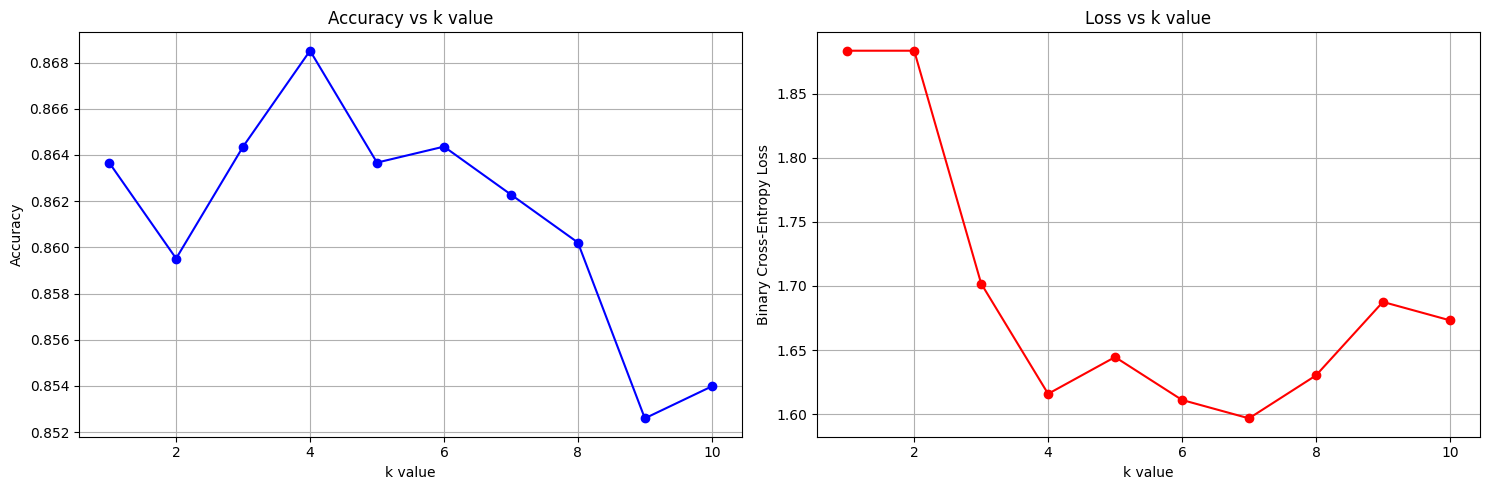

In [17]:
# data preparation
df['gold_label'] = df['gold_label'].fillna('')
df['gold_label'] = df['gold_label'].str.split(',')

# Remove empty strings from lists
df['gold_label'] = df['gold_label'].apply(lambda x: [label.strip() for label in x if label.strip()])

# Initialize and fit the MultiLabelBinarizer
mlb = CustomMultiLabelBinarizer()
y = np.array(mlb.fit_transform(df['gold_label']))

# Rest of the code remains the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store results
k_values = range(1, 11)
accuracies = []
losses = []  

# Calculate metrics for each k
for k in k_values:
    knn = ImprovedSparseMultiLabelKNN(k=k)
    knn.fit(X_train, y_train)  
    y_pred = knn.predict(X_test)  
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate binary cross-entropy loss
    epsilon = 1e-15  # To avoid log(0)
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_test * np.log(y_pred_clipped) + 
                    (1 - y_test) * np.log(1 - y_pred_clipped))
    losses.append(loss)

# Create figure with two subplots
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, 'bo-')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k value')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(k_values, losses, 'ro-')
plt.xlabel('k value')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss vs k value')
plt.grid(True)

plt.tight_layout()
plt.show()

_Note: The best k thus established is *k=6*, giving both the highest accuracy on the *test set* at round 93% and the least error._

Finding the Best Hyperparameters and **testing the model**.

Best k value: 4 with accuracy: 0.8685


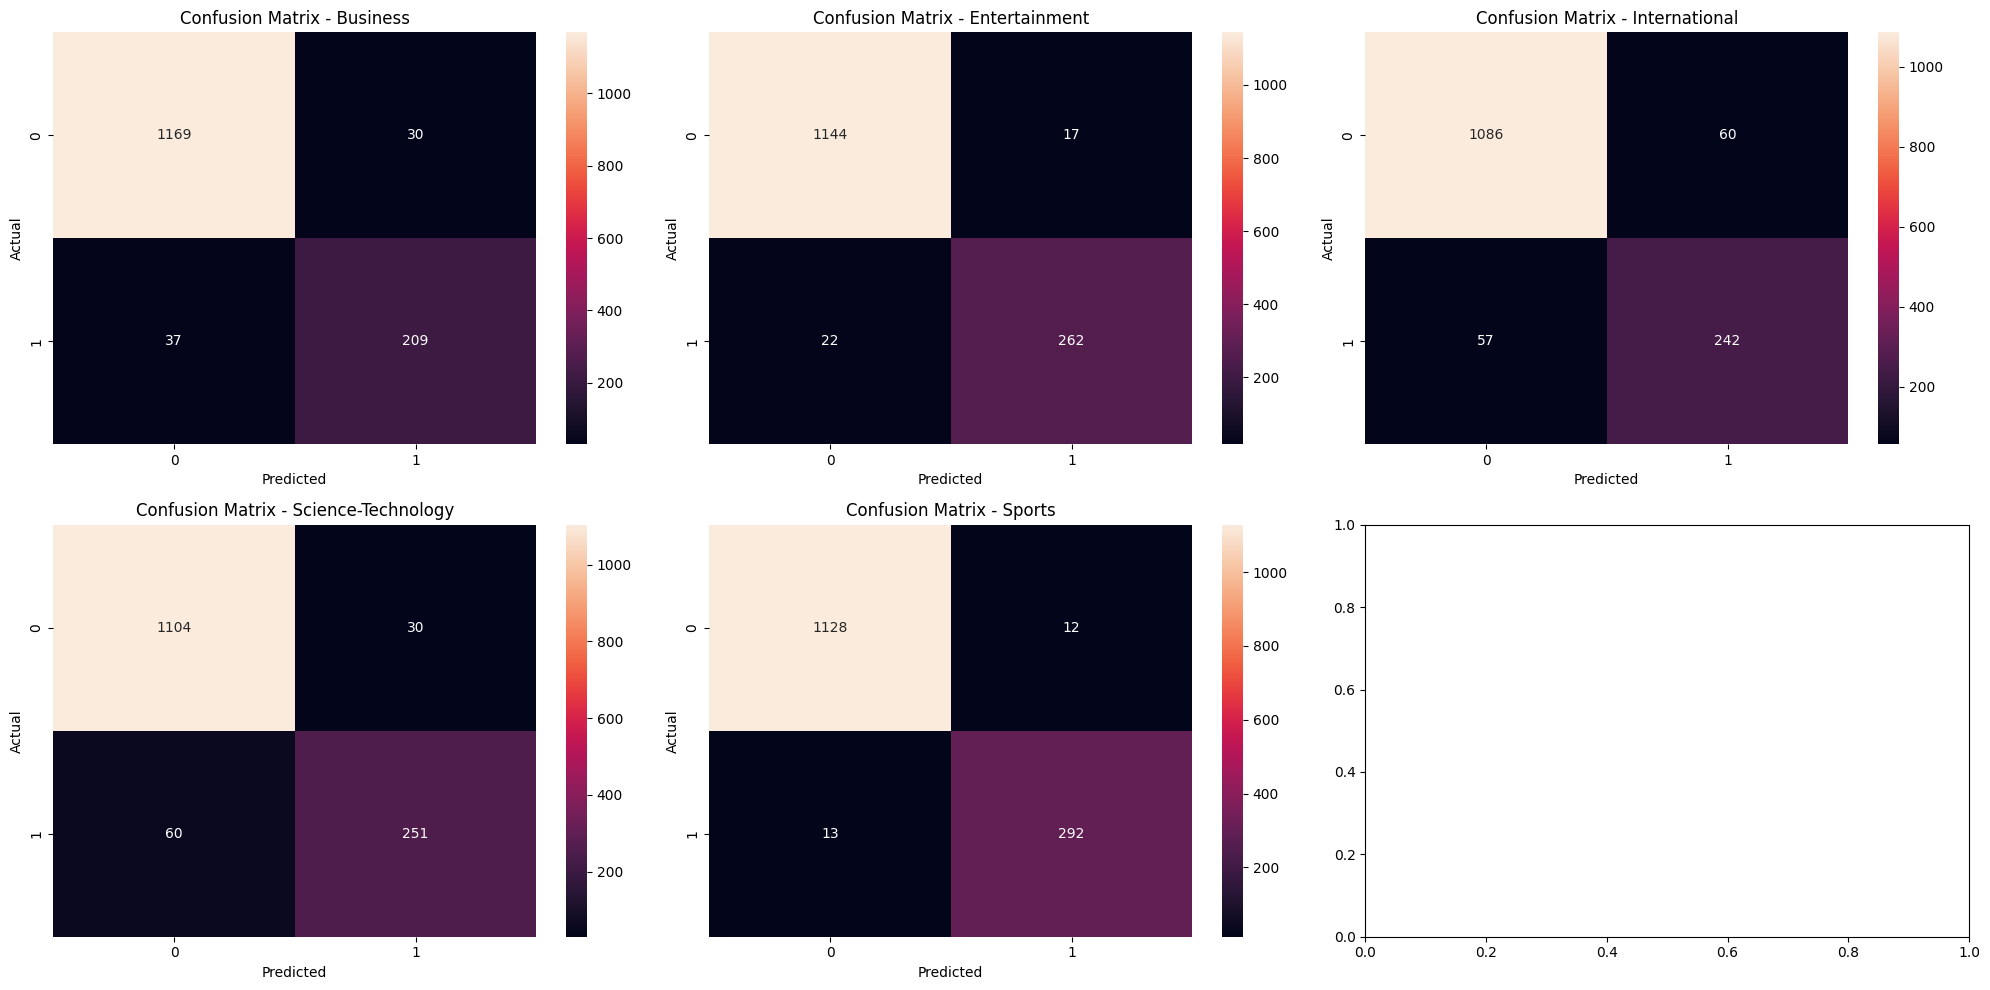

In [18]:
# Find best k value
best_k = k_values[np.argmax(accuracies)]
print(f"Best k value: {best_k} with accuracy: {max(accuracies):.4f}")

# Generate confusion matrices for best k
knn = ImprovedSparseMultiLabelKNN(k=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Plot confusion matrix for each label
n_labels = len(mlb.classes_)
fig, axes = plt.subplots(2, (n_labels + 1) // 2, figsize=(20, 10))
axes = axes.ravel()

for i in range(n_labels):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {mlb.classes_[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

##### Testing on Externally Source Data *(to mimic the real-world scenario)*

- The test is on `DAWN` dataset, which follows a similar distribution as our training set.

In [19]:
# Load the new dataset
new_df = pd.read_csv('../data/dawn_dataset_c.csv')

# Preprocess the content
new_df['content'] = new_df['content'].apply(lambda x: clean_content(x, urdu_stopwords))

# Transform the new data using the existing custom_vectorizer
X_new = custom_vectorizer.transform(new_df['content'])

# Predict using the trained model
y_pred_new = knn.predict(X_new)

# If the new dataset has labels, evaluate the performance
if 'gold_label' in new_df.columns:
    # Prepare labels
    new_df['gold_label'] = new_df['gold_label'].fillna('')
    new_df['gold_label'] = new_df['gold_label'].str.split(',')
    new_df['gold_label'] = new_df['gold_label'].apply(lambda x: [label.strip() for label in x if label.strip()])
    y_new = mlb.transform(new_df['gold_label'])

    # Evaluate performance
    print("Accuracy on new dataset:", accuracy_score(y_new, y_pred_new))
    print("\nClassification Report on new dataset:")
    print(classification_report(y_new, y_pred_new, target_names=mlb.classes_))
else:
    # Convert predictions to labels
    predicted_labels = mlb.inverse_transform(y_pred_new)

    # Add predictions to the dataframe
    new_df['predicted_labels'] = [';'.join(labels) for labels in predicted_labels]

    # Save predictions to CSV
    new_df.to_csv('./data/dawn_dataset_predictions.csv', index=False)

    # Display the predictions
    print(new_df[['content', 'predicted_labels']])

Accuracy on new dataset: 0.8888888888888888

Classification Report on new dataset:
                    precision    recall  f1-score   support

          Business       0.85      0.90      0.88        63
     Entertainment       0.50      0.33      0.40         3
     International       0.91      0.99      0.95       149
Science-Technology       0.94      0.79      0.86        19
            Sports       0.00      0.00      0.00         0

         micro avg       0.89      0.94      0.92       234
         macro avg       0.64      0.60      0.62       234
      weighted avg       0.89      0.94      0.91       234
       samples avg       0.91      0.94      0.92       234



C:\Users\ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMet

- The test is on `BBC` dataset, which follows a different distribution as our training set with long articles.

In [20]:
# Load the new dataset
new_df = pd.read_csv('../data/bbc_dataset_c.csv')

# Preprocess the content
new_df['content'] = new_df['content'].apply(lambda x: clean_content(x, urdu_stopwords))

# Transform the new data using the existing custom_vectorizer
X_new = custom_vectorizer.transform(new_df['content'])

# Predict using the trained model
y_pred_new = knn.predict(X_new)

# If the new dataset has labels, evaluate the performance
if 'gold_label' in new_df.columns:
    # Prepare labels
    new_df['gold_label'] = new_df['gold_label'].fillna('')
    new_df['gold_label'] = new_df['gold_label'].str.split(',')
    new_df['gold_label'] = new_df['gold_label'].apply(lambda x: [label.strip() for label in x if label.strip()])
    y_new = mlb.transform(new_df['gold_label'])

    # Evaluate performance
    print("Accuracy on new dataset:", accuracy_score(y_new, y_pred_new))
    print("\nClassification Report on new dataset:")
    print(classification_report(y_new, y_pred_new, target_names=mlb.classes_))
else:
    # Convert predictions to labels
    predicted_labels = mlb.inverse_transform(y_pred_new)

    # Add predictions to the dataframe
    new_df['predicted_labels'] = [';'.join(labels) for labels in predicted_labels]

    # Save predictions to CSV
    new_df.to_csv('./data/dawn_dataset_predictions.csv', index=False)

    # Display the predictions
    print(new_df[['content', 'predicted_labels']])

Accuracy on new dataset: 0.8963414634146342

Classification Report on new dataset:
                    precision    recall  f1-score   support

          Business       0.96      0.94      0.95       222
     Entertainment       0.93      0.94      0.94       240
     International       0.87      0.90      0.88       208
Science-Technology       0.89      0.75      0.81       239
            Sports       0.96      0.97      0.97       239

         micro avg       0.92      0.90      0.91      1148
         macro avg       0.92      0.90      0.91      1148
      weighted avg       0.92      0.90      0.91      1148
       samples avg       0.90      0.90      0.90      1148



C:\Users\ahmed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*Thank you for bearing through this end*.<br>
For testing your dataset, please change one of the above *External Test Datasets* to your dataset and run the code. The notebook will automatically test the model on the new dataset. Please ensure that the file direcotry is correct and the dataset is in the same format as the training and testing datasets. See *Testing your dataset* section in the report for more details.
###### (c) Habibi Group, Fall 2024